# Rubber Motors

Before we get started, we need a little setup to access **wart** data for examples on this page.

In [2]:
import os
import sys
from pathlib import Path
cwd = !pwd
pagedir = Path(cwd[0])

projpath = pagedir / ".." / ".."
projdir = projpath.absolute().as_posix()
if not projdir in sys.path:
        sys.path.insert(0,projdir)

In [3]:
import mmtime

Probably the most difficult part of the indoor model analysis process is figuring out how to manage the rubber motor. Obviously, the motor is important, but there are many variables to consider. 

Basically, we pick a strand of rubber from some batch we have acquired. That strand has a cross section we can measure with calipers. We cut the strand, then tie a knot to form a loop that has some final length, then lubricate it with some magic lotion. The final motor has a weight that we can easily measure. All of this is simple enough to document. The big issue is what kind of *power* will that motor supply to our model and how will that power vary over time as a flight proceeds.

To get power out of the motor, we need to wind it up. The big initial question is how many turns do we put into the motor. Oh,by the way, exactly how we wind the motor has some bearing on how much power it will deliver. Stretching it will let us pack in more winds, and builders develop a feel for how much stretching they should do. As we wind it up, knots will form and those knots need to be managed so they do not bunch up and get stuck on the structure somehow.

Phew! That is a lot to consider. Some of these issues will defy analysis (like that thing called "feel"). So, how do we handle the analysis of this motor? Let's take this is stages.

## Motor Available Energy

In Doug McLean's paper, we see this formula for the total energy we can get out of a rubber motor:

\begin{equation}
E = K_m w_m
\end{equation}

Where $K_m$ is a constant equal to 30,000 inches and $w_m$ is the motor weight. Basically, this formula says that the energy we can get out of a rubber motor is proportional to the weight of the motor. That will be a maximum amount we might get, since the other variables will determine the actual energy available for each flight. Let's see how much energy was available for Gary's record flight.

In [4]:
import pint
u = pint.UnitRegistry()
from mmtime.data.models.wart import data
wart = data.Wart(u)
mdata = wart.model_data()

In [5]:
w_m = mdata['weights']['rubber']
w_m

0.86 <Unit('gram')>

Hacklinger's energy calculation gives this result:

In [6]:
import pint
u = pint.UnitRegistry()
from mmtime.data.models.wart import data
wart = data.Wart(u)
mdata = wart.model_data()
w_m = mdata['weights']['rubber']
K_m = 30000 * u.inch
E = K_m * w_m * u.gravity
E.to('ft*lbf')

4.739938636974868 <Unit('foot * force_pound')>

Carl Bakay presented a study of rubber in volume 102 of INAX {cite}`bakay2001`. in this article, Carl showed how to determine the available energy using just a stretching test. These tests provide a better estimate of the energy we might get from a particular motor, since manufacturing procedures will deliver different performance for each rubber batch, regardless of the weight of the motor. Here is a sample energy value obtained from stretch testing. The number provided was in energy per pound of the rubber sample.

In [7]:
sample = 3596 * u.feet * u.lbf / u.pounds 
sample.to_base_units()
sample = sample * 0.81 * u.grams
sample.to('ft*lbf')

6.421536588016241 <Unit('foot * force_pound')>

That number is significantly higher than Don's formula gives. Perhaps that is a sign that the current rubber is not as good as that available back in 2001. In any case, the available energy level seems pretty high, but that is why a broken motor can destroy a model!

## Motor Winds

The bare weight of the motor may provide us with a measure of the possible energy we can get out of each motor, but we need to wind it up to get any useful power out of the motor. Don Slusarczyk {cite}`slusarczyk2014` presented a simple formula that will tell us approximately how many turns we can pack into the motor. 

\begin{equation}
K = \frac{N_{max}}{m_l}\sqrt{\frac{m_w}{m_l}}
\end{equation}

Where $K$ is a constant Don set to 8.5. $m_l$ is the motor length in inches, $N_{max}$ is the predicted breaking turn count, and $w_m$ is the motor weight in ounces. 

Don provided a test case that will give us the correct value for $K$, and the associated units we need:

In [8]:
Nmax = 2000
w_l = 0.04094 * u.ounces
m_l = 14.0 * u.inch
m_w = 0.0494 * u.ounces
K = Nmax / m_l * ( m_w / m_l)**0.5
K.to('ounce**0.5/inch**1.5')

8.485968525017059 <Unit('ounce ** 0.5 / inch ** 1.5')>

This calculation produces the constant and it also provides the proper units for that constant. Knowing that, we can set up a simple *Python* function that will take a motor weight and loop length and return the predicted maximun turn count for that motor:

In [9]:
def max_turns(length, weight):
    K = 8.48597 * u.ounce**0.5/u.inch**1.5
    Nmax = K * length / (weight/length)**0.5
    return Nmax

Let's check the functon with the example case:

In [10]:
Nt = max_turns(m_l,m_w)
Nt.to_base_units()

2000.000347628662 <Unit('dimensionless')>

Now we check another point on the Don's graph:

In [11]:
lt = 10.0 * u.inch
wt = 0.25 * u.gram
Nt = max_turns(lt,wt)
Nt.to_base_units()

2857.6192758072957 <Unit('dimensionless')>

Now, let's plug in Gary's record flight numbers:

In [12]:
w_m = mdata['weights']['rubber']
m_l = mdata['motor']['length']
Nw = max_turns(m_l, w_m)
Nw.to_base_units()

3720.7792374854744 <Unit('dimensionless')>

Gary launched his record flight with 3660 turns, which looks reasonable using this function to calculate a maximum turn limit! He was probably safe, since measuring the loop length is often done after the knot is tied, and the exact length is a bit hard to get with the motor in a loop.

## Torque Curve

Once we have a motor ready to go, it must be wound up for a flight. Builders sometimes just count the turns and fly, but it is better to attach the motor to a torque measuring device and wind to some specific torque value. It is easy to measure the torque as it is wound. You simply stop winding at multiple points and record the turn and torque value. This gives us a curve that represents how torque varies with turn count. However, that is not the full story. As the motor delivers power to the propeller as it unwinds, the torque curve will not be the same. A hysteresis effect enters into the picture, meaning that the torque delivered to the propeller at each turn count is lower from the wound torque at the same count value. Measuring this is difficult and data reflecting the delivered torque is difficult to find. Here is a diagram from Carl Bakay's article showing this effect:

In [13]:
projdir

'/Users/rblack/_dev/live-2022/book/content/../..'

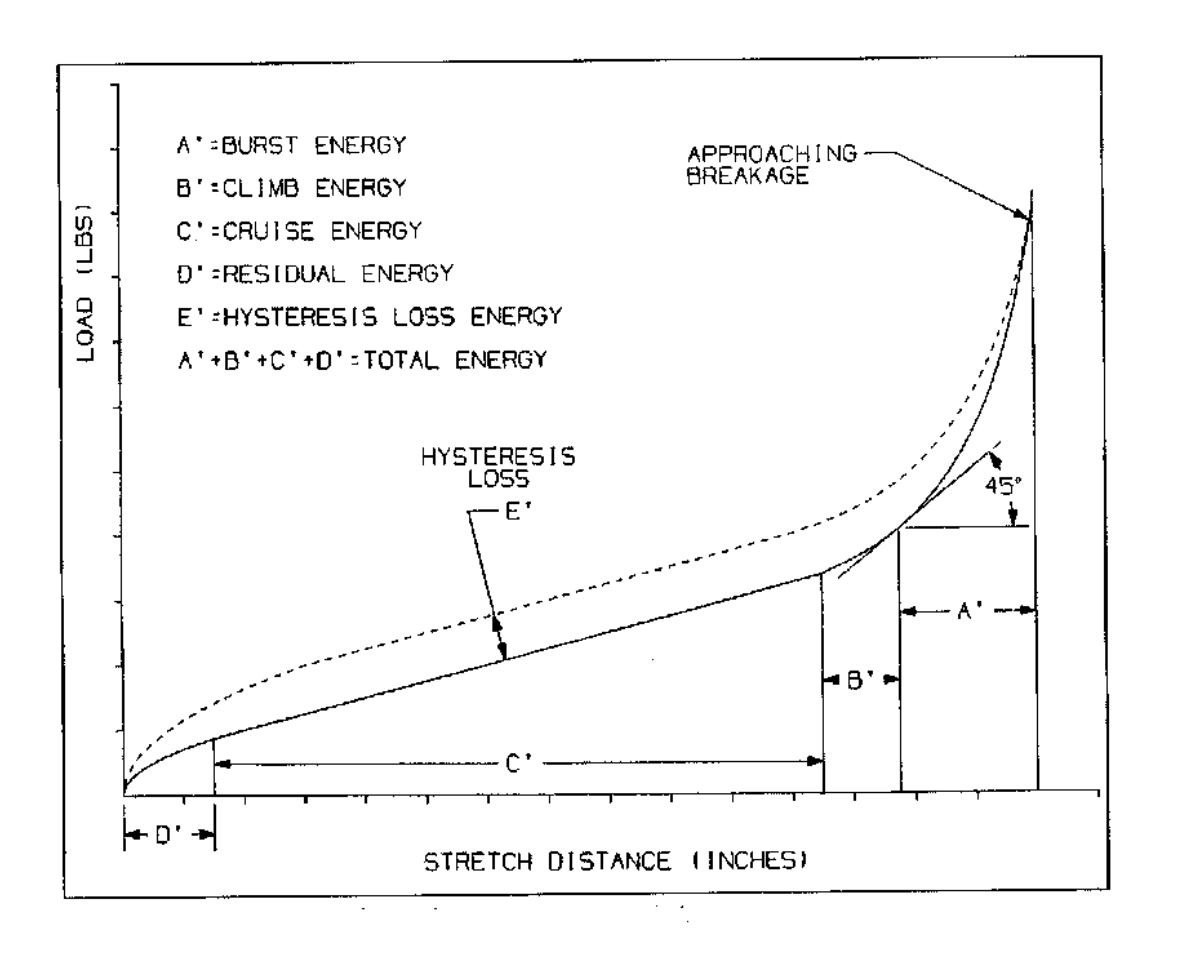

In [14]:
from IPython.display import Image
fname = projpath / 'assets' / 'images' / 'torque-curve-inav-aug-01.png'
Image(filename = fname)

This figure gives us a variety of parameters we might use to model a rubber motor. For flight analysis, we are not really interested in the load data, except that it certainly has an effect on the structure of the motor stick! The energy delivered to the propeller is what we want to examine. A simple approach is to assume a fixed percentage loss that accounts for the hysteresis effect. I have seen estimates ranging from 25-30 percent, so we can add this as another parameter for study.

For the purposes of this study, we will set up a simple analytical curve that models a rubber motor. From this figure, I will use simple polynomial curves for segments **A** and **B** and **D** above, and a straight line for segment  **C**.

### Analytic Torque Curve

To generate a torque function we can use for study, we first define a few sample points on the curve. The axes we will be using are torque as a function of turns, so the maximum turn cont and launch torque will be our first point. The second point will be the point where the cruise begins. The third point will be at the end of that cruise portion. The final point is the landing point, which we will assume is when the motor fully winds down. THis is obviously an ideal curve, since models often land before the winds run totally out. The two polynomial segments must match slopes at the ends of the cruise segment.

Here is the basic setup:

In [15]:
%reload_ext tikzmagic

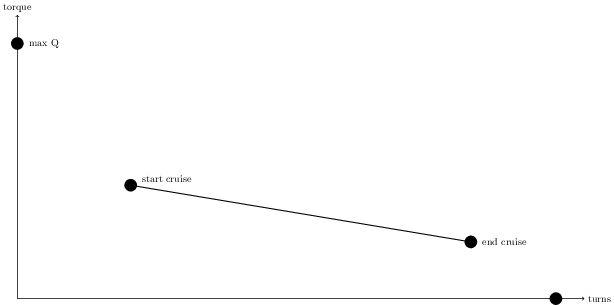

In [16]:
%%tikz -l calc --scale=2

% draw axes

\draw[thin,->] (0,0) -- (10,0) node[right]{turns};
\draw[thin,->] (0,0) -- (0,5) node[above]{torque};

% max torque point
\filldraw (0,4.5) circle (3pt) node[right, xshift=8pt] {max Q};
% start cruise point
\filldraw (2,2) circle (3pt) node[above right,xshift=8pt] {start cruise}; 
% end cruise point
\filldraw (8,1) circle (3pt) node[right,xshift=8pt] {end cruise};
% end flight point
\filldraw(9.5,0) circle (3pt);

\draw [thick] (2,2) -- (8,1);

We need to find the polynomials that complete this curve. We will use the data points and match slopes to the cruise line.

Assume the polynomial of this form:

\begin{equation}
y = Ax^2 + Bx + C
\end{equation}

The derivative of this curve is:

\begin{equation}
\frac{dy}{dx} = M_c = 2ax + B
\end{equation}

We will match the curve values at the end points, and the slope at one end point. This will give us three equations for three unknowns.

For the first polynomial, we have:
\begin{equation}
Q_{max} = C
\end{equation}

\begin{equation}
y_{c0} = Ax_{c0}^2 + Bx_{c0} + Q_{max}
\end{equation}

\begin{equation}
\frac{y_{c1} - y_{c0}}{x_{c1} - x_{c0}} = M_c = 2Ax_{c0} + B
\end{equation}

Let's let **sympy** grind out this math:

In [17]:
import sympy
Qm, x1, y1, x2, y2, Nm = sympy.symbols('Qm x1 y1 x2 y2 Nm')

For simplicity, we will introduce **M** as the slope of the cruise segment.

In [18]:
A, B, C, M = sympy.symbols('A B C M')

In [19]:
eq1 = Qm - C
eq2 = -M + 2*A*x1 + B
eq3 = A*x1**2 + B*x1 + C - y1
sympy.solve([eq1,eq2,eq3],[A,B,C])

{A: (M*x1 + Qm - y1)/x1**2, B: (-M*x1 - 2*Qm + 2*y1)/x1, C: Qm}

For the second curve, the equations are a bit different. We will set up the polynomial so it curves from zero at $N_{max}$ and matches the slope at the end of the curve. To get this curve, we set up the polynomial so $x_p = N_m - x$, which is  is zero at $x_p = 0$ and increases to the left. The new equations we need are:


In [20]:
eq4 = A*(Nm - x2)**2 + B*(Nm-x2) + C - y2
eq5 = C 
eq6 = M + 2*A*(Nm - x2) + B
sympy.solve([eq4,eq5,eq6],[A,B,C])

{A: (-M*Nm + M*x2 - y2)/(Nm**2 - 2*Nm*x2 + x2**2),
 B: (-M*Nm + M*x2 - 2*y2)/(-Nm + x2),
 C: 0}

Messy, but coding this is easy!

In [21]:
def torque(n, Qm,x1,y1,x2,y2,Nm):
    M = (y2 - y1)/(x2 - x1)
    if n<x1: 
        A = (M*x1 + Qm - y1)/x1**2
        B = (-M*x1 - 2*Qm + 2*y1)/x1
        C = Qm
        return A*n**2 + B*n + C
    elif n < x2:
        M = (y2 - y1)/(x2 - x1)
        return y1 + M*(n - x1)
    else:
        xp = Nm-n
        A = (-M*Nm + M*x2 - y2)/(Nm**2 - 2*Nm*x2 + x2**2)
        B = (-M*Nm + M*x2 - 2*y2)/(-Nm + x2)
        C = 0
        return A*xp**2 + B*xp + C


We have not really included the hysteresis effect in this curve. If we want to generate a fixed hysteresis loss to this curve, we need to adjust the cruise end points in some manner so the area under the adjusted curve is some percentage of the original area. This is not simple to do since the effect may be more pronounced at one end of the cruise line rather than the other. We will look at this later.

Let's plot a sample torque curve and see what we get:

In [22]:
import numpy as mp
import matplotlib.pyplot as plt

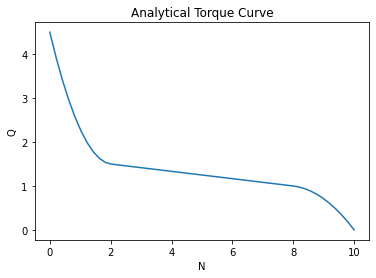

In [23]:
tQm = 4.5
tNm = 10
tx1 = 2
ty1 = 1.5
tx2 = 8
ty2 = 1
from mmtime.utils import show_curve
n = np.linspace(0,tNm, 50)
Q = []
for nx in n:
    Q.append(torque(nx,tQm,tx1,ty1,tx2,ty2,tNm))
show_curve(n,Q,"Analytical Torque Curve","N","Q")

This curve looks reasonable at the end of the winds, but is too sharp in transitioning to the cruise. We could improve this by trying higher order polynomials, but we will stop here.

This curve shows the problem with a cubic curve. Depending on where we position the 4 degree point, we can generate a curve that is not what we want at all! We will use the first version of the torque function for the rest of this analysis and revisit the scheme later.

We want to scale this curve so the maximum torque matches the launch torque, and the maximum turn count matches the launch turn count.

### Analytical Wart Curve

Let's run this plot again, using the Wart values:

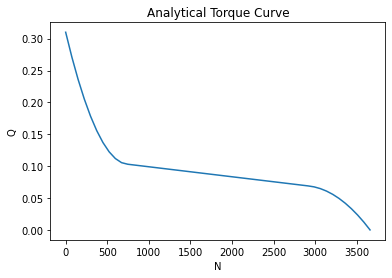

In [39]:
tQm = 0.31
tNm = 3660
tx1 = 0.2 * tNm
ty1 = 0.333 * tQm
tx2 = 0.8 * tNm
ty2 = 0.222 * tQm
from mmtime.utils import show_curve
n = np.linspace(0,tNm, 50)
Q = []
for nx in n:
    Q.append(torque(nx,tQm,tx1,ty1,tx2,ty2,tNm))
show_curve(n,Q,"Analytical Torque Curve","N","Q")

Now, let's use the same scheme we used in the analysis of Bud Tenny's data to find the average torque:

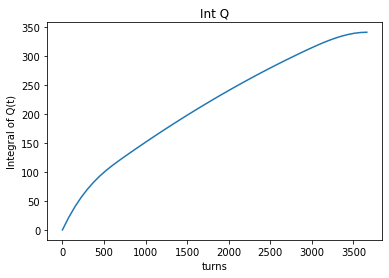

In [29]:
ni = n
qi = Q
dn = ni[-1]/50
ai = [0]
for i in range(len(ni)-1):
    da = (qi[i+1] + qi[i])*dn/2
    ai.append(ai[i]+da)
show_curve(ni,ai,"Int Q", "turns", "Integral of Q(t)")

Now we use the hacky scheme to get the average torque:

In [31]:
for i in range(len(ni)):
    if ai[i]> ai[-1]/2:
        average = qi[i] * u.inch*u.ounce
        print("Average Torque is",average, " which happened at turn count:",ni[i])
        break


Average Torque is 0.0948030612244898 inch * ounce  which happened at turn count: 1269.795918367347


Now, let's try Hacklinger's equation again!

In [38]:
import math
winds = 3660
Qavg = average
W_r = 0.86 * u.grams
He = 900 * u.meters
N_r = 6.6480308871856035 / u.second
time = He * W_r /(2.0*math.pi *Qavg *N_r)
time.to_base_units()

271.4352383959889 <Unit('second')>

This is off by a factor of two, but I have not included a hysteresis effect. To simulate tis, let's move the cruise portion of the torque down by 40%:

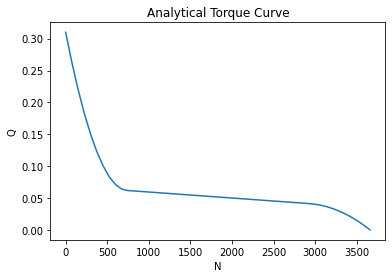

In [46]:
hysterisus = 0.6
tQm = 0.31
tNm = 3660
tx1 = 0.2 * tNm
ty1 = (0.333 * tQm)*hysterisus
tx2 = 0.8 * tNm
ty2 = (0.222 * tQm)*hysterisus
from mmtime.utils import show_curve
n = np.linspace(0,tNm, 50)
Q = []
for nx in n:
    Q.append(torque(nx,tQm,tx1,ty1,tx2,ty2,tNm))
show_curve(n,Q,"Analytical Torque Curve","N","Q")

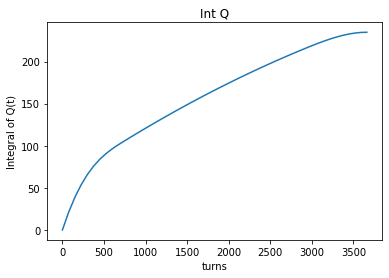

In [47]:
ni = n
qi = Q
dn = ni[-1]/50
ai = [0]
for i in range(len(ni)-1):
    da = (qi[i+1] + qi[i])*dn/2
    ai.append(ai[i]+da)
show_curve(ni,ai,"Int Q", "turns", "Integral of Q(t)")

In [61]:
for i in range(len(ni)):
    if ai[i]> ai[-1]/2:
        average = qi[i] * u.inch*u.ounce
        print("Average Torque is",average, " which happened at turn count:",ni[i])
        break

Average Torque is 0.059690816326530616 inch * ounce  which happened at turn count: 971.0204081632653


In [66]:
import math
winds = 3660
Qavg = 0.0547 * u.inch * u.ounce
W_r = 0.86 * u.grams
He = 900 * u.meters
N_r = 6.648 /u.second
time = He * W_r /(2.0*math.pi *Qavg *N_r)
time.to_base_units()

470.43895944037854 <Unit('second')>

Better, but perhaps the the average RPM estimate is too high for this calculation.

In McLean's discussion, he used the RPM for level flight, which is what our propeller analysis produced. I have seen some discussions that use the torque value about half way along the flat portion of the torque curve. This happens at around 1500 turns:

In [63]:
average = torque(1500,tQm,tx1,ty1,tx2,ty2,tNm)
Qavg = average * u.inch * u.ounce
Qavg

0.05471754098360656 <Unit('inch * ounce')>

In [64]:
time = He * W_r /(2.0*math.pi *Qavg *N_r)
time.to_base_units()

470.2881492627447 <Unit('second')>